In [1]:
import numpy as np
import MSMRD as mrd
import MSMRD.integrators as integrators
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#define MSMmodel class to read in data
class MSMmodel(object):    
    def __init__(self, tmatrix, centers, parameters):
        self.tmatrix = tmatrix
        self.centers= centers
        self.parameters = parameters

In [3]:
def discreteHistogram(data):
    d = np.diff(np.unique(data)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    hist = plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d), normed=True)
    centers = (hist[1][1:] + hist[1][:-1])/2
    return hist, centers

In [4]:
model = pickle.load(open('../data/asym2D_inner_lag50.p'))

In [5]:
print model.parameters

{'NangularPartitions': 15, 'bathRadius': 2.0, 'NCenters': 9, 'entryRadius': 2.0, 'outerBathRadius': 2.0, 'interactionRadius': 2.0, 'lagtime': 50}


In [6]:
msm = mrd.MSM(model.tmatrix, model.centers)

In [7]:
#overwrite exit states, now there is only 1 state from which the MSM can be exited
msm.exitStates = []

In [8]:
#print just for checking
print msm.exitStates
print msm.entryStates

[]
[0]


In [9]:
p = mrd.particle(np.array([1.0, 0.0]), 1.)
integrator = integrators.MSMRDexitSampling(msm, 2.0, p, 0.05, model.parameters)

In [10]:
sim = mrd.simulation(integrator)
sim.run(10000000, sample=True)

In [12]:
print sim.traj

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]
 [  5.00000000e-02   0.00000000e+00   0.00000000e+00   1.00000000e+00]
 [  1.00000000e-01   0.00000000e+00   0.00000000e+00   1.00000000e+00]
 ..., 
 [  4.99998500e+04   0.00000000e+00   0.00000000e+00   8.00000000e+00]
 [  4.99999000e+04   0.00000000e+00   0.00000000e+00   8.00000000e+00]
 [  4.99999500e+04   0.00000000e+00   0.00000000e+00   8.00000000e+00]]


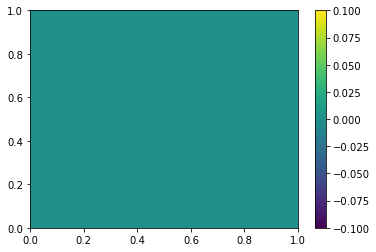

In [13]:
BDregion = np.where(sim.traj[:,3]==-1)[0]
obj = plt.hist2d(sim.traj[BDregion,1], sim.traj[BDregion,2], bins=200)
plt.colorbar()

In [11]:
class asym2DmilestoningMSMRD(object):
    def __init__(self, bathRadius, Ncenters):
        self.bathRadius = bathRadius
        self.Ncenters = Ncenters
        self.Nstates = Ncenters
    
    def getState(self, sample, prevstate):
        #check BD region first
        if sample[2] == -1:
            if np.linalg.norm(sample[:2]) > self.bathRadius:
                return self.Ncenters
            else:
                return prevstate
        else:
            if sample[2] < self.Ncenters:
                return sample[2]
            else:
                return prevstate
            
    def computeMilestoningTraj(self, traj):
        self.dTraj = np.zeros(len(traj))
        self.dTraj[0] = 0
        for i in range(1, len(traj)):
            self.dTraj[i] = self.getState(traj[i], self.dTraj[i-1])
            
    def computeMeanTransitionTimes(self, timestep):
        sumTau = np.zeros((self.Nstates, self.Nstates))
        counts = np.zeros((self.Nstates, self.Nstates))
        tau = 0
        for i in range(len(self.dTraj)):
            if self.dTraj[i] == self.dTraj[i-1]:
                tau += 1
            else:
                sumTau[self.dTraj[i-1], self.dTraj[i]] += tau
                counts[self.dTraj[i-1], self.dTraj[i]] += 1
                tau = 0
        nonzeros = np.where(counts!=0)[0]
        self.meanTransitionTimes = np.zeros_like(counts)
        for i in range(0, int(self.Nstates)):
            for j in range(0, int(self.Nstates)):
                if counts[i,j] != 0:
                    self.meanTransitionTimes[i,j] = sumTau[i,j] / counts[i,j] * timestep
        self.counts = counts

In [12]:
def computeMeanTransitionTimes(timestep, mobj):
    sumTau = np.zeros((mobj.Nstates, mobj.Nstates))
    counts = np.zeros((mobj.Nstates, mobj.Nstates))
    for dTraj in [mobj.dTraj]:
        i = 0
        tau = 1
        statesVisited = [dTraj[0]]
        transitionFrom = dTraj[0]
        nextTransitionIndex = -1
        while i<len(dTraj)-1:
            i += 1
            if dTraj[i] == dTraj[i-1]:
                tau += 1
            else:
                if len(statesVisited) == mobj.Nstates:
                    transitionFrom = dTraj[nextTransitionIndex]
                    statesVisited = [transitionFrom]
                    i = nextTransitionIndex
                    nextTransitionIndex = -1
                    tau = 1 
                elif not np.in1d(dTraj[i], statesVisited):
                    sumTau[transitionFrom, dTraj[i]] += tau
                    counts[transitionFrom, dTraj[i]] += 1
                    if nextTransitionIndex < 0:
                        nextTransitionIndex = i
                    statesVisited.append(dTraj[i])
                    tau +=1
                else:
                    tau += 1
    meanTransitionTimes = np.zeros((mobj.Nstates, mobj.Nstates))
    for i in range(0, mobj.Nstates):
        for j in range(0, mobj.Nstates):
            if counts[i,j] != 0:
                meanTransitionTimes[i,j] = sumTau[i,j] / counts[i,j] * timestep
    return meanTransitionTimes

In [13]:
milestoning = asym2DmilestoningMSMRD(2.0, 9)
milestoning.computeMilestoningTraj(sim.traj[:,1:4])

In [16]:
milestoning.computeMeanTransitionTimes(0.05)

/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [14]:
MTT = computeMeanTransitionTimes(0.05, milestoning)

/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


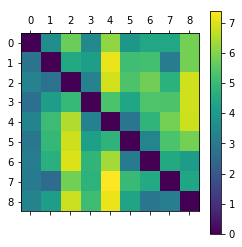

In [15]:
plt.matshow(MTT)
plt.colorbar()
#plt.clim((0., 5.0))

In [21]:
import pickle
BDtransitionTimes = pickle.load(open('2DasymMTT_inner_fromT_lag1.p'))

/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


nan

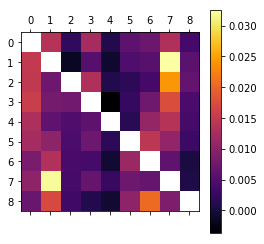

In [22]:
diff = (MTT - BDtransitionTimes)/BDtransitionTimes
plt.matshow(diff, cmap=plt.get_cmap('inferno'))
#plt.clim((-0.2,0.3))
plt.colorbar()
np.amax(diff)

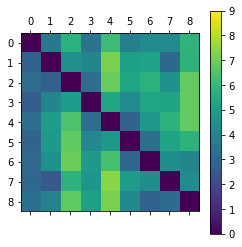

In [18]:
plt.matshow(BDtransitionTimes)
plt.clim(0,9)
plt.colorbar()

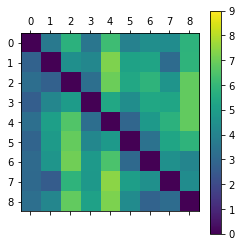

In [29]:
plt.matshow(MTT)
plt.clim(0,9)
plt.colorbar()

In [20]:
#compute milestoning trajectory
#1 corresponds to the unbound, 0 to the bound state
b = np.zeros(len(sim.traj))
boundStates = np.where(np.linalg.norm(model.centers, axis=1) <= 1.0)[0]
for i in range(len(sim.traj)):
    if sim.traj[i, 3] == -1:
        if np.linalg.norm(sim.traj[i,1:3]) >= 3.0:
            b[i] = 1
        else:
            b[i] = b[i-1]
    else:
        if np.in1d(sim.traj[i,3], boundStates):
            b[i] = 0
        else:
            b[i] = b[i-1]

In [21]:
print np.sum(b)/len(b)

0.7962722


In [25]:
transitions = b[1:]-b[:-1]
AtoB = np.where(transitions == 1)[0]
BtoA = np.where(transitions == -1)[0]
def transitionTimes(AtoB, BtoA):
    if len(AtoB) == len(BtoA):
        if AtoB[0] < BtoA[0]:
            print "case1"
            tauBtoA = BtoA - AtoB
            tauAtoB = AtoB[1:] - BtoA[:-1]
        else:
            print "case2"
            tauAtoB = AtoB - BtoA
            tauBtoA = BtoA[1:] - AtoB[:-1]
    elif len(AtoB)+1 == len(BtoA):
        if AtoB[0] < BtoA[0]:
            print "case3"
            tauBtoA = BtoA[:-1] - AtoB
            tauAtoB = AtoB[1:] - BtoA[:-2]
        else:
            print "case4"
            tauAtoB = AtoB - BtoA[:-1]
            tauBtoA = BtoA[1:] - AtoB
    elif len(AtoB)-1 == len(BtoA):
        if AtoB[0] < BtoA[0]:
            print "case5"
            tauBtoA = BtoA - AtoB[:-1]
            tauAtoB = AtoB[1:] - BtoA
        else:
            print "case6"
            tauAtoB = AtoB[:-1] - BtoA
            tauBtoA = BtoA[1:-1] - AtoB[:-2]
    else:
        return None
    return tauAtoB, tauBtoA
tauAtoB, tauBtoA = transitionTimes(AtoB, BtoA)

case2


In [27]:
timestep = 0.05
print "mean tauBtoA", np.mean(timestep*tauBtoA)
print "mean tauAtoB", np.mean(timestep*tauAtoB)
print "std tauBtoA", np.std(timestep*tauBtoA)
print "std tauAtoB", np.std(timestep*tauAtoB)
print "mean stationary distribution", np.sum(b)/len(b)

mean tauBtoA 6.8667661314
mean tauAtoB 1.75694056366
std tauBtoA 6.40886492939
std tauAtoB 1.3277413142
mean stationary distribution 0.7962722


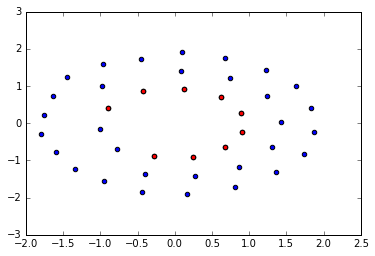

In [28]:
plt.scatter(model.centers[:,0], model.centers[:,1])
boundStates = np.where(np.linalg.norm(model.centers, axis=1) <= 1.0)[0]
plt.scatter(model.centers[boundStates,0], model.centers[boundStates,1], c='r')

In [46]:
print boundStates

[ 1  2  3  8  9 13 15 18 22]


In [69]:
print (len(np.where(np.logical_and(sim.traj[:,3]==-1, np.linalg.norm(sim.traj[:,1:3], axis=1)<3.0))[0])+len(np.where(sim.traj[:,3]!=-1)[0]))/float(len(sim.traj))

0.885895


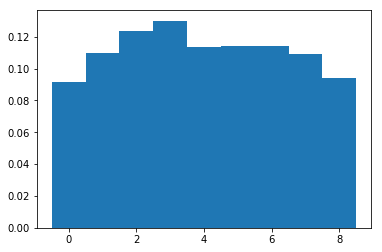

In [62]:
dhist = discreteHistogram(sim.traj[:,3])

In [64]:
import pyemma
M = pyemma.msm.markov_model(model.tmatrix)

In [65]:
stat_distr = M.stationary_distribution

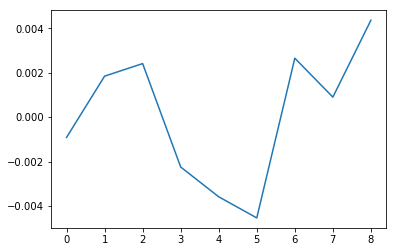

In [70]:
plt.plot((dhist[0][0]-stat_distr)/stat_distr)

In [68]:
dhist[0][0]

array([ 0.091426 ,  0.1098041,  0.1238055,  0.130026 ,  0.1133568,
        0.1142068,  0.1140577,  0.1093922,  0.0939249])

In [71]:
dhist[0][0].shape

(9,)

In [72]:
dhist

((array([ 0.091426 ,  0.1098041,  0.1238055,  0.130026 ,  0.1133568,
          0.1142068,  0.1140577,  0.1093922,  0.0939249]),
  array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5]),
  <a list of 9 Patch objects>),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]))

In [77]:
np.histogram(sim.traj[:,3])[0]

array([ 914260, 1098041, 1238055, 1300260,       0, 1133568, 1142068,
       1140577, 1093922,  939249])